In [ ]:
DOWNLOAD_FROM_KAGGLE = False
DOWNLOAD_FROM_DRIVE = True

**Importing Libraries**

---



In [ ]:
!pip install -U xgboost

In [ ]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import log_loss





---



**Import from Drive**

---



In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


**Kaggle Dataset**

---



In [ ]:
if DOWNLOAD_FROM_KAGGLE:
  !pip install kaggle
  files.upload()

  !mkdir -p "content/drive/My Drive/Kaggle"

  !cp kaggle.json /root/.kaggle/
  !chmod 600 /root/.kaggle/.kaggle.json

  !kaggle datasets download -d dhoogla/nfunswnb15v2
  !unzip nfunswnb15v2.zip




---



**Google Drive**

In [ ]:
if DOWNLOAD_FROM_DRIVE:
    # Load from Google Drive to local
    !cp /content/drive/MyDrive/Kaggle_Datasets/NF-UNSW-NB15-V2/NF-UNSW-NB15-V2.parquet NF-UNSW-NB15-V2.parquet
    !cp /content/drive/MyDrive/Kaggle_Datasets/NF-UNSW-NB15-V2/NetFlow-v2-Features.csv NetFlow-v2-Features.csv
else:
    # Save from local to Google Drive
    !cp NF-UNSW-NB15-V2.parquet /content/drive/MyDrive/Kaggle_Datasets/NF-UNSW-NB15-V2/NF-UNSW-NB15-V2.parquet
    !cp NetFlow-v2-Features.csv /content/drive/MyDrive/Kaggle_Datasets/NF-UNSW-NB15-V2/NetFlow-v2-Features.csv


In [ ]:
!cp -r /content/drools-distribution-8.44.0.Final /content/drive/MyDrive/Kaggle_Datasets/




---



**DATA Handling**

Creating Dataset and train/val/test sets
---



In [ ]:
# Make dataframe
df = pd.read_parquet('NF-UNSW-NB15-V2.parquet')

In [ ]:
#df.shape
print("---------FEATURES-----------")
print(df.dtypes)
print("---------LABEL-----------")
print(df.Label.value_counts())
print("---------ATTACK-----------")
print(df.Attack.value_counts())


---------FEATURES-----------
L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                         int16
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int16
OUT_BYTES                        int32
OUT_PKTS                         int16
TCP_FLAGS                         int8
CLIENT_TCP_FLAGS                  int8
SERVER_TCP_FLAGS                  int8
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int16
DURATION_OUT                     int16
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int16
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int16
SRC_TO_DST_SECOND_BYTES        float32
DST_TO_SRC_SECOND_BYTES        float32
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          in

In [ ]:
df.head(10)

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,1305,21,6,1.0,9,1,193,3,24,24,...,0,7240,0,0,0,0,0,331.0,0,Benign
1,1305,21,6,1.0,261,5,469,7,24,24,...,8688,8688,18944,74,0,0,0,230.0,0,Benign
2,1305,21,6,1.0,481,9,750,11,24,24,...,10136,10136,33792,132,0,0,0,229.0,0,Benign
3,1305,21,6,1.0,701,13,1054,15,24,24,...,11584,11584,48640,190,0,0,0,125.0,0,Benign
4,1305,21,6,1.0,1031,19,1474,21,24,24,...,14480,13032,64256,251,0,0,0,230.0,0,Benign
5,1305,21,6,1.0,1251,23,1751,25,24,24,...,15928,14480,13568,53,0,0,0,229.0,0,Benign
6,1305,21,6,1.0,1493,27,2054,29,24,24,...,17376,15928,31232,122,0,0,0,125.0,0,Benign
7,42208,21,6,1.0,309,7,556,7,24,24,...,16383,16383,38400,150,0,0,0,227.0,0,Benign
8,1305,21,6,1.0,1817,33,2510,35,24,24,...,20272,17376,46080,180,0,0,0,229.0,0,Benign
9,1305,21,6,1.0,2059,37,2814,39,24,24,...,21720,18824,63744,249,0,0,0,125.0,0,Benign


In [ ]:
print("Tyoes of Attacks:\n " ,df['Attack'].unique())

Tyoes of Attacks:
  ['Benign' 'Exploits' 'Generic' 'Fuzzers' 'Backdoor' 'DoS' 'Reconnaissance'
 'Shellcode' 'Worms' 'Analysis']


In [ ]:
X = df.drop(columns = ['Label', 'Attack']).values
y = df['Label'].values

X_drools =df.drop(columns = ['Attack'])
# Save to CSV, ensuring the label column is last
X_drools.to_csv('/content/X_drools.csv', index=False)





   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0         1305           21         6       1.0         9        1        193   
1         1305           21         6       1.0       261        5        469   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  NUM_PKTS_1024_TO_1514_BYTES  \
0         3         24                24  ...                            0   
1         7         24                24  ...                            0   

   TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  ICMP_TYPE  ICMP_IPV4_TYPE  DNS_QUERY_ID  \
0               0             7240          0               0             0   
1            8688             8688      18944              74             0   

   DNS_QUERY_TYPE  DNS_TTL_ANSWER  FTP_COMMAND_RET_CODE  Label  
0               0               0                 331.0      0  
1               0               0                 230.0      0  

[2 rows x 42 columns]


In [ ]:
X_drools_test = df.drop(columns = ['Attack']).tail(8940)
X_drools_test.to_csv('/content/X_drools_test.csv', index=False)

In [ ]:
print(X_drools.head())
print(X.shape)
print(y.shape)

   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0         1305           21         6       1.0         9        1        193   
1         1305           21         6       1.0       261        5        469   
2         1305           21         6       1.0       481        9        750   
3         1305           21         6       1.0       701       13       1054   
4         1305           21         6       1.0      1031       19       1474   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  NUM_PKTS_1024_TO_1514_BYTES  \
0         3         24                24  ...                            0   
1         7         24                24  ...                            0   
2        11         24                24  ...                            0   
3        15         24                24  ...                            0   
4        21         24                24  ...                            0   

   TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  ICMP_TYP

**Create Dataset and loaders**

---



In [ ]:
class createCustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype = torch.float32)
    self.labels = torch.tensor(labels, dtype = torch.float32)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

batch_size = 32

# Original full dataset
dataset = createCustomDataset(X, y)
original_size = len(dataset)


fraction = 0.03
reduced_size = int(fraction * original_size)

subset_indices = np.random.choice(original_size, reduced_size, replace=False)


subset_dataset = torch.utils.data.Subset(dataset, subset_indices)
# split sizes
train_size = int(0.7 * len(subset_dataset))
val_size = int(0.15 * len(subset_dataset))
test_size = len(subset_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

train_data = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_data = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_data = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# We need to convert the dataloader to a Numpy if we are only using XGBoost !!!
def dataloader_to_numpy(dataloader):
    features = []
    labels = []
    for batch_features, batch_labels in dataloader:
        features.append(batch_features.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Convert DataLoaders --> Numpy
X_train, y_train = dataloader_to_numpy(train_data)
X_val, y_val = dataloader_to_numpy(val_data)
X_test, y_test = dataloader_to_numpy(test_data)


print("Training Set Size" , len(train_dataset))
print("Validation Set Size" , len(val_dataset))
print("Testing Set Size" , len(test_dataset))



Training Set Size 41721
Validation Set Size 8940
Testing Set Size 8941


**Machine Learning**

XGBoost --> Feature Selection --> Distillation
---




In [ ]:
# XGBoost model
model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    eval_metric=['logloss', 'error'],
    tree_method="hist"  # Use "gpu_hist" if you have a GPU
)

# Train Model
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

In [ ]:
from sklearn.metrics import accuracy_score
y_test_pred = model.predict(X_test)

# Accuracy of XG
original_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {original_test_accuracy * 100:.2f}%")

Test Accuracy: 99.55%


**Analyze the DT and get Rule Threshholds for Drools**

---



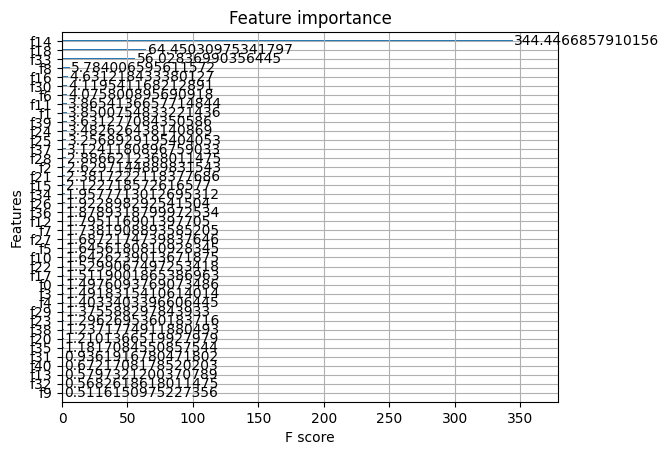

In [ ]:
xgb.plot_importance(model, importance_type = "gain" )
plt.show()

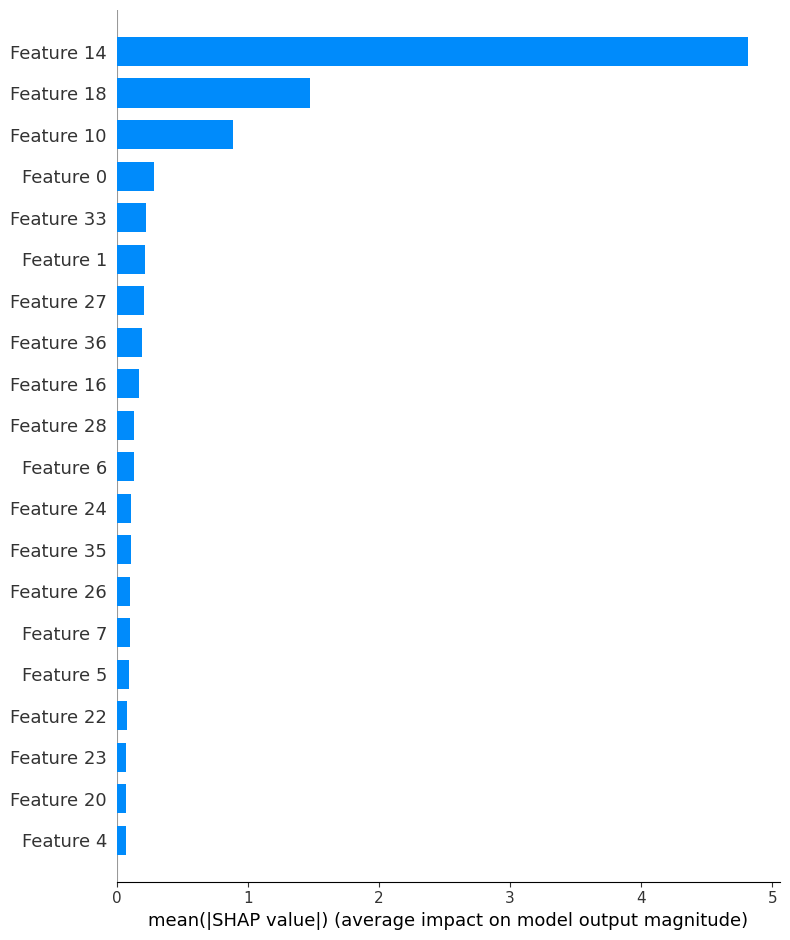

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
mean_shap_per_tree = shap_values.mean(axis=0)
print("Mean SHAP per Tree:", mean_shap_per_tree)

Mean SHAP per Tree: [ 1.16727814e-01  1.36655167e-01  1.24992058e-02  1.41729219e-02
  6.65511563e-02 -7.24453107e-02  1.06014639e-01 -8.58949721e-02
 -2.84062745e-03  1.45584513e-02 -8.70430887e-01  1.79771613e-02
 -5.13137178e-03 -2.98378430e-03 -4.26594639e+00 -7.64035201e-03
  1.48324981e-01  1.01150209e-02 -1.40769625e+00  0.00000000e+00
  4.66184318e-02  4.64102551e-02 -4.42154557e-02  4.99560535e-02
  7.87757188e-02 -3.64349931e-02  3.54234837e-02  1.91127270e-01
 -1.15786396e-01  1.98543202e-02  8.03491939e-03 -1.80914998e-03
  2.47337837e-02 -2.03232229e-01 -1.60873663e-02 -9.40963253e-03
 -8.47409144e-02 -2.56512463e-02 -1.81105305e-02  2.71972356e-04
  3.71433003e-03]


In [ ]:
feature_mapping = {f"f{i}": col for i, col in enumerate(df.columns)}
print("Feature Mapping:", feature_mapping)

important_feature_name = feature_mapping["f0"]
print("Important Feature:", important_feature_name)

Feature Mapping: {'f0': 'L4_SRC_PORT', 'f1': 'L4_DST_PORT', 'f2': 'PROTOCOL', 'f3': 'L7_PROTO', 'f4': 'IN_BYTES', 'f5': 'IN_PKTS', 'f6': 'OUT_BYTES', 'f7': 'OUT_PKTS', 'f8': 'TCP_FLAGS', 'f9': 'CLIENT_TCP_FLAGS', 'f10': 'SERVER_TCP_FLAGS', 'f11': 'FLOW_DURATION_MILLISECONDS', 'f12': 'DURATION_IN', 'f13': 'DURATION_OUT', 'f14': 'MIN_TTL', 'f15': 'MAX_TTL', 'f16': 'LONGEST_FLOW_PKT', 'f17': 'SHORTEST_FLOW_PKT', 'f18': 'MIN_IP_PKT_LEN', 'f19': 'MAX_IP_PKT_LEN', 'f20': 'SRC_TO_DST_SECOND_BYTES', 'f21': 'DST_TO_SRC_SECOND_BYTES', 'f22': 'RETRANSMITTED_IN_BYTES', 'f23': 'RETRANSMITTED_IN_PKTS', 'f24': 'RETRANSMITTED_OUT_BYTES', 'f25': 'RETRANSMITTED_OUT_PKTS', 'f26': 'SRC_TO_DST_AVG_THROUGHPUT', 'f27': 'DST_TO_SRC_AVG_THROUGHPUT', 'f28': 'NUM_PKTS_UP_TO_128_BYTES', 'f29': 'NUM_PKTS_128_TO_256_BYTES', 'f30': 'NUM_PKTS_256_TO_512_BYTES', 'f31': 'NUM_PKTS_512_TO_1024_BYTES', 'f32': 'NUM_PKTS_1024_TO_1514_BYTES', 'f33': 'TCP_WIN_MAX_IN', 'f34': 'TCP_WIN_MAX_OUT', 'f35': 'ICMP_TYPE', 'f36': 'ICMP

**Learnt DTs from XGBoost**

*Pretty complicated we should somehow make it less complex*

In [ ]:
# Dump the trees into a text
trees = model.get_booster().get_dump(with_stats=True)

for i, tree in enumerate(trees):
    print(f"Tree {i}:\n{tree}\n")

# This is a very complicated Tree, not necessary.. We should distill

**Make the Trees less complex (DISTILLATION)**

---



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Use XGBoost predictions as target for distillation
y_pred_train = model.predict(X_train)
distillation_model = DecisionTreeClassifier(max_depth=20)
distillation_model.fit(X_train, y_pred_train)

DecisionTreeClassifier(max_depth=20)

In [ ]:
y_test_pred = distillation_model.predict(X_test)

# Accuracy on Distilled Model
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Original Model Accuracy: {original_test_accuracy * 100:.2f}%")
print(f"Distilled Model Accuracy: {test_accuracy * 100:.2f}%")

Original Model Accuracy: 99.55%
Distilled Model Accuracy: 99.46%


In [ ]:
from sklearn.tree import export_text
# Dump the trees into a text format
# Print the structure of the distilled decision tree
tree_rules = export_text(distillation_model, feature_names=list(df.drop(columns = ['Label' , 'Attack']).columns))
print(tree_rules)

|--- MIN_TTL <= 61.00
|   |--- PROTOCOL <= 3.50
|   |   |--- class: 1
|   |--- PROTOCOL >  3.50
|   |   |--- LONGEST_FLOW_PKT <= 1502.50
|   |   |   |--- SRC_TO_DST_SECOND_BYTES <= 64.00
|   |   |   |   |--- SHORTEST_FLOW_PKT <= 50.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SHORTEST_FLOW_PKT >  50.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- SRC_TO_DST_SECOND_BYTES >  64.00
|   |   |   |   |--- class: 0
|   |   |--- LONGEST_FLOW_PKT >  1502.50
|   |   |   |--- class: 1
|--- MIN_TTL >  61.00
|   |--- TCP_WIN_MAX_IN <= 17339.50
|   |   |--- MAX_IP_PKT_LEN <= 45.00
|   |   |   |--- L4_DST_PORT <= 1391.00
|   |   |   |   |--- SRC_TO_DST_AVG_THROUGHPUT <= 260000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SRC_TO_DST_AVG_THROUGHPUT >  260000.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- L4_DST_PORT >  1391.00
|   |   |   |   |--- class: 0
|   |   |--- MAX_IP_PKT_LEN >  45.00
|   |   |   |--- SRC_TO_DST_AVG_THROUGHPUT <= 516000.00
|   |   |   |   

**XGBoost/DT too Drools Rule**

We Want to make a Parser or Similar for automated Rule Creation between Distilled DT and Drools
---

In [ ]:
# Tree structure
tree = distillation_model.tree_


for node in range(tree.node_count):
    # Check if leaf node
    if tree.children_left[node] == tree.children_right[node]:  # This is a leaf node
        print(f"Leaf node {node}, Value: {tree.value[node]}")
    else:
        # Get the feature and threshold for the split
        feature = tree.feature[node]
        threshold = tree.threshold[node]
        print(f"Node {node}, Feature: {df.columns[feature]}, Threshold: {threshold}")

  # write rules.drl
    # when ...
      # do
        # ....

Node 0, Feature: MIN_TTL, Threshold: 61.0
Node 1, Feature: PROTOCOL, Threshold: 3.5
Leaf node 2, Value: [[0. 1.]]
Node 3, Feature: LONGEST_FLOW_PKT, Threshold: 1502.5
Node 4, Feature: SRC_TO_DST_SECOND_BYTES, Threshold: 64.0
Node 5, Feature: SHORTEST_FLOW_PKT, Threshold: 50.0
Leaf node 6, Value: [[1. 0.]]
Leaf node 7, Value: [[0. 1.]]
Leaf node 8, Value: [[1. 0.]]
Leaf node 9, Value: [[0. 1.]]
Node 10, Feature: TCP_WIN_MAX_IN, Threshold: 17339.5
Node 11, Feature: MAX_IP_PKT_LEN, Threshold: 45.0
Node 12, Feature: L4_DST_PORT, Threshold: 1391.0
Node 13, Feature: SRC_TO_DST_AVG_THROUGHPUT, Threshold: 260000.0
Leaf node 14, Value: [[1. 0.]]
Leaf node 15, Value: [[0. 1.]]
Leaf node 16, Value: [[1. 0.]]
Node 17, Feature: SRC_TO_DST_AVG_THROUGHPUT, Threshold: 516000.0
Node 18, Feature: SRC_TO_DST_SECOND_BYTES, Threshold: 344.0
Leaf node 19, Value: [[0.76923077 0.23076923]]
Leaf node 20, Value: [[0.248 0.752]]
Node 21, Feature: OUT_BYTES, Threshold: 423.0
Leaf node 22, Value: [[0.03510759 0.96

In [ ]:
# Tree structure
tree = distillation_model.tree_

def traverse_tree(node, conditions):
    # Check if leaf node
    if tree.children_left[node] == tree.children_right[node]:  # Leaf node
        rule = " && ".join(conditions) + f" => {tree.value[node]}"
        print(f"Drools Rule: if ({rule})")
    else:
        feature = tree.feature[node]
        threshold = tree.threshold[node]

        traverse_tree(tree.children_left[node], conditions + [f"{df.columns[feature]} <= {threshold}"])

        traverse_tree(tree.children_right[node], conditions + [f"{df.columns[feature]} > {threshold}"])

# Start traversal from root with empty conditions
traverse_tree(0, [])

Drools Rule: if (MIN_TTL <= 61.0 && PROTOCOL <= 3.5 => [[0. 1.]])
Drools Rule: if (MIN_TTL <= 61.0 && PROTOCOL > 3.5 && LONGEST_FLOW_PKT <= 1502.5 && SRC_TO_DST_SECOND_BYTES <= 64.0 && SHORTEST_FLOW_PKT <= 50.0 => [[1. 0.]])
Drools Rule: if (MIN_TTL <= 61.0 && PROTOCOL > 3.5 && LONGEST_FLOW_PKT <= 1502.5 && SRC_TO_DST_SECOND_BYTES <= 64.0 && SHORTEST_FLOW_PKT > 50.0 => [[0. 1.]])
Drools Rule: if (MIN_TTL <= 61.0 && PROTOCOL > 3.5 && LONGEST_FLOW_PKT <= 1502.5 && SRC_TO_DST_SECOND_BYTES > 64.0 => [[1. 0.]])
Drools Rule: if (MIN_TTL <= 61.0 && PROTOCOL > 3.5 && LONGEST_FLOW_PKT > 1502.5 => [[0. 1.]])
Drools Rule: if (MIN_TTL > 61.0 && TCP_WIN_MAX_IN <= 17339.5 && MAX_IP_PKT_LEN <= 45.0 && L4_DST_PORT <= 1391.0 && SRC_TO_DST_AVG_THROUGHPUT <= 260000.0 => [[1. 0.]])
Drools Rule: if (MIN_TTL > 61.0 && TCP_WIN_MAX_IN <= 17339.5 && MAX_IP_PKT_LEN <= 45.0 && L4_DST_PORT <= 1391.0 && SRC_TO_DST_AVG_THROUGHPUT > 260000.0 => [[0. 1.]])
Drools Rule: if (MIN_TTL > 61.0 && TCP_WIN_MAX_IN <= 17339.5 

In [ ]:
tree = distillation_model.tree_

output_file = "drools_rules.drl"

rule_counter = 1

# Recursive function to traverse the tree and collect rules
def traverse_tree(node, conditions):

    global rule_counter
    # Base case: Check if leaf node
    if tree.children_left[node] == tree.children_right[node]:  # Leaf node
        classification = 1 if tree.value[node][0][0] > 0 else 0  # Example logic, adapt as needed
        print(classification)
        # Create a rule with the accumulated conditions
        rule_name = f"Rule_{rule_counter}"
        rule = f'rule "{rule_name}"\nwhen\n'

        # Combine all conditions within a single FactClass declaration
        combined_conditions = ", ".join(conditions)
        rule += f"    $fact: FactClass({combined_conditions})\n"

        #rule += f'then\n    // Action for leaf node {node}, Value: {tree.value[node]}\nend\n\n'
        #rule += f'then\n    // Action for leaf node {node}, Value: {tree.value[node]}\n'

        # Add the action to set classification

        rule += f'then\n    $fact.setClassification({classification});\n'

        rule += f'    System.out.println("{rule_name} matched: {classification}");\n'
        rule += "end\n\n"
        # Write the rule to the file
        with open(output_file, "a") as file:
            file.write(rule)

        rule_counter += 1
    else:
        # Get the feature and threshold for the split
        feature = tree.feature[node]
        threshold = tree.threshold[node]

        traverse_tree(tree.children_left[node], conditions + [f"{df.columns[feature]} <= {threshold}"])

        traverse_tree(tree.children_right[node], conditions + [f"{df.columns[feature]} > {threshold}"])

with open(output_file, "w") as file:
    file.write("// Drools rules generated from Decision Tree\n\n")
    #file.write("import FactClass;\n\n")

# Begin traversal to generate rules
traverse_tree(0, [])

print(f"Drools rules saved to {output_file}")


**Drools**

Java enviorment needed
---



In [ ]:
!apt-get update
!apt-get install -y openjdk-11-jdk

In [ ]:
!wget https://download.jboss.org/drools/release/8.44.0.Final/drools-distribution-8.44.0.Final.zip
!unzip drools-distribution-8.44.0.Final.zip

In [ ]:
!wget https://repo1.maven.org/maven2/org/slf4j/slf4j-simple/2.0.9/slf4j-simple-2.0.9.jar -P /content/drools-distribution-8.44.0.Final/binaries

In [ ]:
# Download the latest compatible Guava version
#!wget -O /content/drools-distribution-7.65.0.Final/binaries/guava-31.1-jre.jar https://repo1.maven.org/maven2/com/google/guava/guava/31.1-jre/guava-31.1-jre.jar
!wget -O /content/drools-distribution-8.44.0.Final/binaries/guava-30.0-jre.jar https://repo1.maven.org/maven2/com/google/guava/guava/33.3.1-jre/guava-33.3.1-jre.jar


**Fact Class**


Can be automated



---



In [ ]:
%%writefile FactClass.java


public class FactClass {
    private double L4_SRC_PORT;
    private double L4_DST_PORT;
    private double PROTOCOL;
    private double L7_PROTO;
    private double IN_BYTES;
    private double IN_PKTS;
    private double OUT_BYTES;
    private double OUT_PKTS;
    private double TCP_FLAGS;
    private double CLIENT_TCP_FLAGS;
    private double SERVER_TCP_FLAGS;
    private double FLOW_DURATION_MILLISECONDS;
    private double DURATION_IN;
    private double DURATION_OUT;
    private double MIN_TTL;
    private double MAX_TTL;
    private double LONGEST_FLOW_PKT;
    private double SHORTEST_FLOW_PKT;
    private double MIN_IP_PKT_LEN;
    private double MAX_IP_PKT_LEN;
    private double SRC_TO_DST_SECOND_BYTES;
    private double DST_TO_SRC_SECOND_BYTES;
    private double RETRANSMITTED_IN_BYTES;
    private double RETRANSMITTED_IN_PKTS;
    private double RETRANSMITTED_OUT_BYTES;
    private double RETRANSMITTED_OUT_PKTS;
    private double SRC_TO_DST_AVG_THROUGHPUT;
    private double DST_TO_SRC_AVG_THROUGHPUT;
    private double NUM_PKTS_UP_TO_128_BYTES;
    private double NUM_PKTS_128_TO_256_BYTES;
    private double NUM_PKTS_256_TO_512_BYTES;
    private double NUM_PKTS_512_TO_1024_BYTES;
    private double NUM_PKTS_1024_TO_1514_BYTES;
    private double TCP_WIN_MAX_IN;
    private double TCP_WIN_MAX_OUT;
    private double ICMP_TYPE;
    private double ICMP_IPV4_TYPE;
    private double DNS_QUERY_ID;
    private double DNS_QUERY_TYPE;
    private double DNS_TTL_ANSWER;
    private double FTP_COMMAND_RET_CODE;

    private String classification; // Classification result
    private String expectedClassification; // Expected classification

    public String getClassification() {
        return classification;
    }

    public void setClassification(String classification) {
        this.classification = classification;
    }

    public String getExpectedClassification() {
        return expectedClassification;
    }

    public void setExpectedClassification(String expectedClassification) {
        this.expectedClassification = expectedClassification;
    }

    // Getters and setters for each field
    public double getL4_SRC_PORT() { return L4_SRC_PORT; }
    public void setL4_SRC_PORT(double L4_SRC_PORT) { this.L4_SRC_PORT = L4_SRC_PORT; }

    public double getL4_DST_PORT() { return L4_DST_PORT; }
    public void setL4_DST_PORT(double L4_DST_PORT) { this.L4_DST_PORT = L4_DST_PORT; }

    public double getPROTOCOL() { return PROTOCOL; }
    public void setPROTOCOL(double PROTOCOL) { this.PROTOCOL = PROTOCOL; }

    public double getL7_PROTO() { return L7_PROTO; }
    public void setL7_PROTO(double L7_PROTO) { this.L7_PROTO = L7_PROTO; }

    public double getIN_BYTES() { return IN_BYTES; }
    public void setIN_BYTES(double IN_BYTES) { this.IN_BYTES = IN_BYTES; }

    public double getIN_PKTS() { return IN_PKTS; }
    public void setIN_PKTS(double IN_PKTS) { this.IN_PKTS = IN_PKTS; }

    public double getOUT_BYTES() { return OUT_BYTES; }
    public void setOUT_BYTES(double OUT_BYTES) { this.OUT_BYTES = OUT_BYTES; }

    public double getOUT_PKTS() { return OUT_PKTS; }
    public void setOUT_PKTS(double OUT_PKTS) { this.OUT_PKTS = OUT_PKTS; }

    public double getTCP_FLAGS() { return TCP_FLAGS; }
    public void setTCP_FLAGS(double TCP_FLAGS) { this.TCP_FLAGS = TCP_FLAGS; }

    public double getCLIENT_TCP_FLAGS() { return CLIENT_TCP_FLAGS; }
    public void setCLIENT_TCP_FLAGS(double CLIENT_TCP_FLAGS) { this.CLIENT_TCP_FLAGS = CLIENT_TCP_FLAGS; }

    public double getSERVER_TCP_FLAGS() { return SERVER_TCP_FLAGS; }
    public void setSERVER_TCP_FLAGS(double SERVER_TCP_FLAGS) { this.SERVER_TCP_FLAGS = SERVER_TCP_FLAGS; }

    public double getFLOW_DURATION_MILLISECONDS() { return FLOW_DURATION_MILLISECONDS; }
    public void setFLOW_DURATION_MILLISECONDS(double FLOW_DURATION_MILLISECONDS) { this.FLOW_DURATION_MILLISECONDS = FLOW_DURATION_MILLISECONDS; }

    public double getDURATION_IN() { return DURATION_IN; }
    public void setDURATION_IN(double DURATION_IN) { this.DURATION_IN = DURATION_IN; }

    public double getDURATION_OUT() { return DURATION_OUT; }
    public void setDURATION_OUT(double DURATION_OUT) { this.DURATION_OUT = DURATION_OUT; }

    public double getMIN_TTL() { return MIN_TTL; }
    public void setMIN_TTL(double MIN_TTL) { this.MIN_TTL = MIN_TTL; }

    public double getMAX_TTL() { return MAX_TTL; }
    public void setMAX_TTL(double MAX_TTL) { this.MAX_TTL = MAX_TTL; }

    public double getLONGEST_FLOW_PKT() { return LONGEST_FLOW_PKT; }
    public void setLONGEST_FLOW_PKT(double LONGEST_FLOW_PKT) { this.LONGEST_FLOW_PKT = LONGEST_FLOW_PKT; }

    public double getSHORTEST_FLOW_PKT() { return SHORTEST_FLOW_PKT; }
    public void setSHORTEST_FLOW_PKT(double SHORTEST_FLOW_PKT) { this.SHORTEST_FLOW_PKT = SHORTEST_FLOW_PKT; }

    public double getMIN_IP_PKT_LEN() { return MIN_IP_PKT_LEN; }
    public void setMIN_IP_PKT_LEN(double MIN_IP_PKT_LEN) { this.MIN_IP_PKT_LEN = MIN_IP_PKT_LEN; }

    public double getMAX_IP_PKT_LEN() { return MAX_IP_PKT_LEN; }
    public void setMAX_IP_PKT_LEN(double MAX_IP_PKT_LEN) { this.MAX_IP_PKT_LEN = MAX_IP_PKT_LEN; }

    public double getSRC_TO_DST_SECOND_BYTES() { return SRC_TO_DST_SECOND_BYTES; }
    public void setSRC_TO_DST_SECOND_BYTES(double SRC_TO_DST_SECOND_BYTES) { this.SRC_TO_DST_SECOND_BYTES = SRC_TO_DST_SECOND_BYTES; }

    public double getDST_TO_SRC_SECOND_BYTES() { return DST_TO_SRC_SECOND_BYTES; }
    public void setDST_TO_SRC_SECOND_BYTES(double DST_TO_SRC_SECOND_BYTES) { this.DST_TO_SRC_SECOND_BYTES = DST_TO_SRC_SECOND_BYTES; }

    public double getRETRANSMITTED_IN_BYTES() { return RETRANSMITTED_IN_BYTES; }
    public void setRETRANSMITTED_IN_BYTES(double RETRANSMITTED_IN_BYTES) { this.RETRANSMITTED_IN_BYTES = RETRANSMITTED_IN_BYTES; }

    public double getRETRANSMITTED_IN_PKTS() { return RETRANSMITTED_IN_PKTS; }
    public void setRETRANSMITTED_IN_PKTS(double RETRANSMITTED_IN_PKTS) { this.RETRANSMITTED_IN_PKTS = RETRANSMITTED_IN_PKTS; }

    public double getRETRANSMITTED_OUT_BYTES() { return RETRANSMITTED_OUT_BYTES; }
    public void setRETRANSMITTED_OUT_BYTES(double RETRANSMITTED_OUT_BYTES) { this.RETRANSMITTED_OUT_BYTES = RETRANSMITTED_OUT_BYTES; }

    public double getRETRANSMITTED_OUT_PKTS() { return RETRANSMITTED_OUT_PKTS; }
    public void setRETRANSMITTED_OUT_PKTS(double RETRANSMITTED_OUT_PKTS) { this.RETRANSMITTED_OUT_PKTS = RETRANSMITTED_OUT_PKTS; }

    public double getSRC_TO_DST_AVG_THROUGHPUT() { return SRC_TO_DST_AVG_THROUGHPUT; }
    public void setSRC_TO_DST_AVG_THROUGHPUT(double SRC_TO_DST_AVG_THROUGHPUT) { this.SRC_TO_DST_AVG_THROUGHPUT = SRC_TO_DST_AVG_THROUGHPUT; }

    public double getDST_TO_SRC_AVG_THROUGHPUT() { return DST_TO_SRC_AVG_THROUGHPUT; }
    public void setDST_TO_SRC_AVG_THROUGHPUT(double DST_TO_SRC_AVG_THROUGHPUT) { this.DST_TO_SRC_AVG_THROUGHPUT = DST_TO_SRC_AVG_THROUGHPUT; }

    public double getNUM_PKTS_UP_TO_128_BYTES() { return NUM_PKTS_UP_TO_128_BYTES; }
    public void setNUM_PKTS_UP_TO_128_BYTES(double NUM_PKTS_UP_TO_128_BYTES) { this.NUM_PKTS_UP_TO_128_BYTES = NUM_PKTS_UP_TO_128_BYTES; }

    public double getNUM_PKTS_128_TO_256_BYTES() { return NUM_PKTS_128_TO_256_BYTES; }
    public void setNUM_PKTS_128_TO_256_BYTES(double NUM_PKTS_128_TO_256_BYTES) { this.NUM_PKTS_128_TO_256_BYTES = NUM_PKTS_128_TO_256_BYTES; }

    public double getNUM_PKTS_256_TO_512_BYTES() { return NUM_PKTS_256_TO_512_BYTES; }
    public void setNUM_PKTS_256_TO_512_BYTES(double NUM_PKTS_256_TO_512_BYTES) { this.NUM_PKTS_256_TO_512_BYTES = NUM_PKTS_256_TO_512_BYTES; }

    public double getNUM_PKTS_512_TO_1024_BYTES() { return NUM_PKTS_512_TO_1024_BYTES; }
    public void setNUM_PKTS_512_TO_1024_BYTES(double NUM_PKTS_512_TO_1024_BYTES) { this.NUM_PKTS_512_TO_1024_BYTES = NUM_PKTS_512_TO_1024_BYTES; }

    public double getNUM_PKTS_1024_TO_1514_BYTES() { return NUM_PKTS_1024_TO_1514_BYTES; }
    public void setNUM_PKTS_1024_TO_1514_BYTES(double NUM_PKTS_1024_TO_1514_BYTES) { this.NUM_PKTS_1024_TO_1514_BYTES = NUM_PKTS_1024_TO_1514_BYTES; }

    public double getTCP_WIN_MAX_IN() { return TCP_WIN_MAX_IN; }
    public void setTCP_WIN_MAX_IN(double TCP_WIN_MAX_IN) { this.TCP_WIN_MAX_IN = TCP_WIN_MAX_IN; }

    public double getTCP_WIN_MAX_OUT() { return TCP_WIN_MAX_OUT; }
    public void setTCP_WIN_MAX_OUT(double TCP_WIN_MAX_OUT) { this.TCP_WIN_MAX_OUT = TCP_WIN_MAX_OUT; }

    public double getICMP_TYPE() { return ICMP_TYPE; }
    public void setICMP_TYPE(double ICMP_TYPE) { this.ICMP_TYPE = ICMP_TYPE; }

    public double getICMP_IPV4_TYPE() { return ICMP_IPV4_TYPE; }
    public void setICMP_IPV4_TYPE(double ICMP_IPV4_TYPE) { this.ICMP_IPV4_TYPE = ICMP_IPV4_TYPE; }

    public double getDNS_QUERY_ID() { return DNS_QUERY_ID; }
    public void setDNS_QUERY_ID(double DNS_QUERY_ID) { this.DNS_QUERY_ID = DNS_QUERY_ID; }

    public double getDNS_QUERY_TYPE() { return DNS_QUERY_TYPE; }
    public void setDNS_QUERY_TYPE(double DNS_QUERY_TYPE) { this.DNS_QUERY_TYPE = DNS_QUERY_TYPE; }

    public double getDNS_TTL_ANSWER() { return DNS_TTL_ANSWER; }
    public void setDNS_TTL_ANSWER(double DNS_TTL_ANSWER) { this.DNS_TTL_ANSWER = DNS_TTL_ANSWER; }

    public double getFTP_COMMAND_RET_CODE() { return FTP_COMMAND_RET_CODE; }
    public void setFTP_COMMAND_RET_CODE(double FTP_COMMAND_RET_CODE) { this.FTP_COMMAND_RET_CODE = FTP_COMMAND_RET_CODE; }
}


Overwriting FactClass.java


In [ ]:
%%writefile MyDroolsApp.java
import org.kie.api.KieServices;
import org.kie.api.builder.KieFileSystem;
import org.kie.api.builder.KieBuilder;
import org.kie.api.builder.KieModule;
import org.kie.api.runtime.KieContainer;
import org.kie.api.runtime.KieSession;
import org.kie.internal.io.ResourceFactory;


public class MyDroolsApp {
    public static void main(String[] args) {
        try {
            System.out.println("Starting Drools rules.");

            // Initialize KieServices and create a KieFileSystem to add the .drl file directly
            KieServices ks = KieServices.Factory.get();
            KieFileSystem kfs = ks.newKieFileSystem();
            kfs.write(ResourceFactory.newFileResource("/content/drools_rules.drl"));

            // Build all and get the KieModule
            KieBuilder kb = ks.newKieBuilder(kfs);
            kb.buildAll();
            KieModule km = kb.getKieModule();

            // Create KieContainer from KieModule
            KieContainer kContainer = ks.newKieContainer(km.getReleaseId());
            KieSession kSession = kContainer.newKieSession();

            // Create an instance of FactClass and set feature values
            FactClass fact = new FactClass();
            fact.setL4_SRC_PORT(12345);
            fact.setL4_DST_PORT(80);
            fact.setPROTOCOL(6);
            fact.setL7_PROTO(7);
            fact.setIN_BYTES(1000);
            fact.setIN_PKTS(10);
            fact.setOUT_BYTES(500);
            fact.setOUT_PKTS(5);
            fact.setTCP_FLAGS(2);
            fact.setCLIENT_TCP_FLAGS(1);
            fact.setTCP_WIN_MAX_IN(5000);
            fact.setTCP_WIN_MAX_OUT(3000);
            fact.setICMP_TYPE(3);
            fact.setICMP_IPV4_TYPE(4);
            fact.setDNS_QUERY_ID(100);
            fact.setDNS_QUERY_TYPE(1);
            fact.setDNS_TTL_ANSWER(300);
            fact.setFTP_COMMAND_RET_CODE(200);

            // Insert the fact into the session and fire rules
            kSession.insert(fact);
            kSession.fireAllRules();
            kSession.dispose();

            System.out.println("Drools rules executed.");
        } catch (Exception e) {
            e.printStackTrace();
        }
    }
}


Overwriting MyDroolsApp.java


In [ ]:
%%writefile MyDroolsApp.java
import org.kie.api.KieServices;
import org.kie.api.builder.KieFileSystem;
import org.kie.api.builder.KieBuilder;
import org.kie.api.builder.KieModule;
import org.kie.api.runtime.KieContainer;
import org.kie.api.runtime.KieSession;
import org.kie.internal.io.ResourceFactory;

import java.io.BufferedReader;
import java.io.FileReader;
import java.util.ArrayList;
import java.util.List;

public class MyDroolsApp {

    public static void main(String[] args) {
        try {
            System.out.println("Starting Drools rules.");

            // Initialize KieServices and create a KieFileSystem to add the .drl file directly
            KieServices ks = KieServices.Factory.get();
            KieFileSystem kfs = ks.newKieFileSystem();
            kfs.write(ResourceFactory.newFileResource("/content/drools_rules.drl"));

            // Build all and get the KieModule
            KieBuilder kb = ks.newKieBuilder(kfs);
            kb.buildAll();
            KieModule km = kb.getKieModule();

            // Create KieContainer from KieModule
            KieContainer kContainer = ks.newKieContainer(km.getReleaseId());
            KieSession kSession = kContainer.newKieSession();

            // Load data and test accuracy
            List<FactClass> facts = loadData("/content/X_drools.csv");
            int correctPredictions = 0;

            for (FactClass fact : facts) {
                // Insert fact into Drools session and fire rules
                kSession.insert(fact);
                kSession.fireAllRules();

                // Compare the predicted classification with the actual label
                System.out.println("Expected Classification: " + fact.getExpectedClassification()); // Ensure expected classification is not null
                System.out.println("Classification: " + fact.getClassification()); // Ensure classification is not null
                if (fact.getClassification().equals(fact.getExpectedClassification())) {
                    correctPredictions++;
                }
                kSession.delete(kSession.getFactHandle(fact));  // Clear fact after processing
            }

            kSession.dispose();

            // Calculate and print accuracy
            double accuracy = (double) correctPredictions / facts.size() * 100;
            System.out.println("Accuracy: " + accuracy + "%");
            System.out.println("Drools rules executed.");

        } catch (Exception e) {
            e.printStackTrace();
        }
    }

    // Method to load data from CSV file
    private static List<FactClass> loadData(String filePath) {
        List<FactClass> facts = new ArrayList<>();
        try (BufferedReader br = new BufferedReader(new FileReader(filePath))) {
            String line;
            // Skip the header row
            line = br.readLine();  // This reads and discards the first line (header)
            while ((line = br.readLine()) != null) {
                String[] fields = line.split(",");

                // Map CSV data to FactClass attributes
                FactClass fact = new FactClass();
                fact.setL4_SRC_PORT(Integer.parseInt(fields[0]));
                fact.setL4_DST_PORT(Integer.parseInt(fields[1]));
                fact.setPROTOCOL(Double.parseDouble(fields[2]));
                fact.setL7_PROTO(Double.parseDouble(fields[3]));
                fact.setIN_BYTES(Integer.parseInt(fields[4]));
                fact.setIN_PKTS(Double.parseDouble(fields[5]));
                fact.setOUT_BYTES(Integer.parseInt(fields[6]));
                fact.setOUT_PKTS(Double.parseDouble(fields[7]));
                fact.setTCP_FLAGS(Double.parseDouble(fields[8]));
                fact.setCLIENT_TCP_FLAGS(Double.parseDouble(fields[9]));
                fact.setSERVER_TCP_FLAGS(Double.parseDouble(fields[10]));
                fact.setFLOW_DURATION_MILLISECONDS(Integer.parseInt(fields[11]));
                fact.setDURATION_IN(Double.parseDouble(fields[12]));
                fact.setDURATION_OUT(Double.parseDouble(fields[13]));
                fact.setMIN_TTL(Double.parseDouble(fields[14]));
                fact.setMAX_TTL(Double.parseDouble(fields[15]));
                fact.setLONGEST_FLOW_PKT(Double.parseDouble(fields[16]));
                fact.setSHORTEST_FLOW_PKT(Double.parseDouble(fields[17]));
                fact.setMIN_IP_PKT_LEN(Double.parseDouble(fields[18]));
                fact.setMAX_IP_PKT_LEN(Double.parseDouble(fields[19]));
                fact.setSRC_TO_DST_SECOND_BYTES(Double.parseDouble(fields[20]));
                fact.setDST_TO_SRC_SECOND_BYTES(Double.parseDouble(fields[21]));
                fact.setRETRANSMITTED_IN_BYTES(Integer.parseInt(fields[22]));
                fact.setRETRANSMITTED_IN_PKTS(Double.parseDouble(fields[23]));
                fact.setRETRANSMITTED_OUT_BYTES(Integer.parseInt(fields[24]));
                fact.setRETRANSMITTED_OUT_PKTS(Double.parseDouble(fields[25]));
                fact.setSRC_TO_DST_AVG_THROUGHPUT(Double.parseDouble(fields[26]));
                fact.setDST_TO_SRC_AVG_THROUGHPUT(Double.parseDouble(fields[27]));
                fact.setNUM_PKTS_UP_TO_128_BYTES(Double.parseDouble(fields[28]));
                fact.setNUM_PKTS_128_TO_256_BYTES(Double.parseDouble(fields[29]));
                fact.setNUM_PKTS_256_TO_512_BYTES(Double.parseDouble(fields[30]));
                fact.setNUM_PKTS_512_TO_1024_BYTES(Double.parseDouble(fields[31]));
                fact.setNUM_PKTS_1024_TO_1514_BYTES(Double.parseDouble(fields[32]));
                fact.setTCP_WIN_MAX_IN(Integer.parseInt(fields[33]));
                fact.setTCP_WIN_MAX_OUT(Integer.parseInt(fields[34]));
                fact.setICMP_TYPE(Integer.parseInt(fields[35]));
                fact.setICMP_IPV4_TYPE(Double.parseDouble(fields[36]));
                fact.setDNS_QUERY_ID(Integer.parseInt(fields[37]));
                fact.setDNS_QUERY_TYPE(Integer.parseInt(fields[38]));
                fact.setDNS_TTL_ANSWER(Double.parseDouble(fields[39]));
                fact.setFTP_COMMAND_RET_CODE(Double.parseDouble(fields[40]));

                // Expected label is assumed to be the last field
                fact.setExpectedClassification(fields[fields.length - 1]);

                facts.add(fact);
            }
        } catch (Exception e) {
            e.printStackTrace();
        }
        return facts;
    }
}

Overwriting MyDroolsApp.java


In [ ]:
!rm -f *.class
!javac -cp ".:/content/drools-distribution-8.44.0.Final/binaries/*" FactClass.java

# Compile both MyDroolsApp.java and FactClass.java in the default package
!javac -cp ".:/content/drools-distribution-8.44.0.Final/binaries/*" FactClass.java MyDroolsApp.java

# Run MyDroolsApp
!java -cp ".:/content/drools-distribution-8.44.0.Final/binaries/*" MyDroolsApp
